## Introduction

The Titanic Kaggle challenge is a good introduction to data science. At the time of this writing, the best tutorials seem to be written in R. To help teach myself Python/Pandas, I borrowed heavily from [Bisaria's lasso/ridge implementation in R](https://www.kaggle.io/svf/272035/c7674afa411b198f92611a43fe7d7c75/__results__.html#lasso-and-ridge-models).  

In this notebook, we predict survivors in the Titanic dataset using lasso and ridge regression methods. Early exploration of data divulges huge disparity in survival ratio between men and women, we trained separate models for men and women. Many observations had the Age variable missing, so we used Multiple Imputation by Chained Equations to impute missing age.

The final result was [score] on the public leaderboard.

### Imports

In [3232]:
%matplotlib inline

import re
import random

import pandas as pd
import numpy as np
import csv as csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics import mosaicplot
from sklearn.tree import DecisionTreeRegressor
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import fancyimpute 

random.seed(100)
np.random.seed(5)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
matplotlib.style.use('ggplot')

### Load Data

In [3233]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

## Exploratory Data Analysis
Let's take a quick peek into the dataset.

In [3234]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [3235]:
train.describe()

/Users/hkwik/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,nan,0.000,0.000,7.910
50%,446.000,0.000,3.000,nan,0.000,0.000,14.454
75%,668.500,1.000,3.000,nan,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


Frequency table of Survived vs. Sex:

In [3236]:
pd.crosstab(train.Survived, train.Sex)

Sex,female,male
Survived,,
0,81,468
1,233,109


In [3237]:
pd.crosstab(train.Survived, train.Sex, normalize=True)

Sex,female,male
Survived,,
0,0.091,0.525
1,0.262,0.122


We see 891 passeengers in the training data, comprising of 314 female and 577 male passengers, out of which 233 females and 109 males survived the disaster. The dataset provides information about each passenger's name, age, gender, port of embarkation, which cabin they booked, their ticket number and fare they paid along with the number of family members they were traveling with. Some of the data like Age and Cabin have a fair amount of missing values, which we'll ignore in our initial exploration of the data.

### Did age influence survival?
Let's look at a scatterplot of the ages of each passenger. This shows that while most of the casualties were male, those below the age of 15 seemed to have a similar survival rate as females within that age group. Females 50 and older seem to have a better survival rate, whereas males 50 and older seem to be worse off than their middle-aged male counterparts. 

We'll use this information when we create new features based on age. 

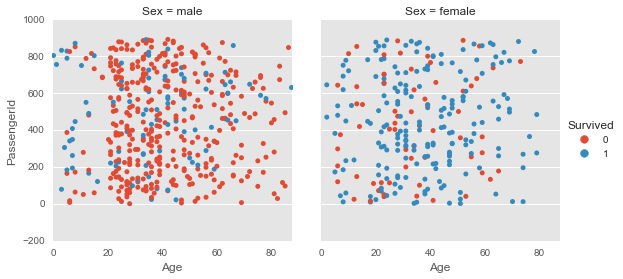

In [3238]:
g = sns.factorplot(x='Age', y='PassengerId', hue='Survived', col='Sex', kind='strip', data=train);
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
plt.show()

### Is survival related to a passenger's class and/or port of embarkation?
Since passengers traveled in different classes, let's check to see if there's any correlation between travel class, where they boarded, and survival.

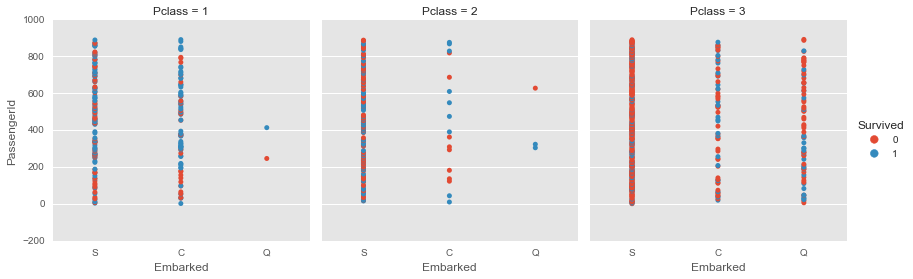

In [3239]:
sns.factorplot(x="Embarked", y="PassengerId", hue="Survived", col="Pclass", kind="strip", data=train);

Most of the passengers who perished had embarked from port ‘S’ and were travelling 3rd class.

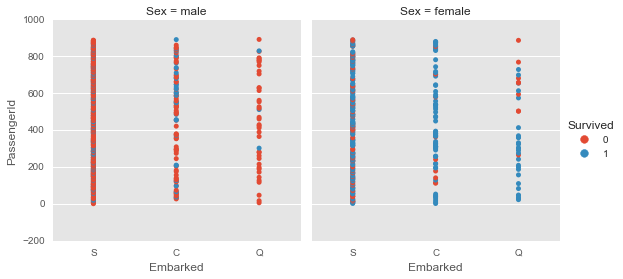

In [3240]:
sns.factorplot(x="Embarked", y="PassengerId", hue="Survived", col="Sex", kind="strip", data=train);

Looks like most of the unfortunate passengers from port ‘S’ travelling 3rd class were male, while most of the casualties among females also happened among passengers from the port ‘S’.

Finally, a combined dataframe of training and test data is created, with 'Survived' removed from the train dataset and saved separately. This will be added to the train dataset after further processing of the combined dataset.

In [3241]:
survived = train['Survived']

test['Survived'] = 0

all_titanic = train.append(test, ignore_index=True)

## Feature Engineering

### Title
The names of the passengers include titles, which we can then use to infer social status. Perhaps passengers with higher social status were more likely to surive. We also look at the minimum and maximum age for each title in our dataset, so we can then infer title when we impute the missing ages. 

In [3242]:
def create_titles(names):
    return [re.split(', |\. ', name)[1] for name in all_titanic.Name]
    
def title_dist():
    unique_titles = all_titanic['Title'].unique()
    n_passengers = [sum(all_titanic['Title'] == title) for title in unique_titles]
    age_missing = [sum((all_titanic['Title'] == title) & (pd.isnull(all_titanic['Age']))) for title in unique_titles]
    min_age = [min(all_titanic.loc[all_titanic['Title'] == title, 'Age']) for title in unique_titles]
    max_age = [max(all_titanic.loc[all_titanic['Title'] == title, 'Age']) for title in unique_titles]

    title_dist = pd.DataFrame({'Title': unique_titles, 'NumPassengers': n_passengers, 'AgeMissing': age_missing, 'MinAge': min_age, 'MaxAge': max_age})
    title_dist.columns.tolist()

    return(title_dist[['Title', 'NumPassengers', 'AgeMissing', 'MinAge', 'MaxAge']])

all_titanic['Title'] = create_titles(all_titanic.Name)
title_dist()

,Title,NumPassengers,AgeMissing,MinAge,MaxAge
0,Mr,757,176,11.000,80.000
1,Mrs,197,27,14.000,76.000
2,Miss,260,50,0.170,63.000
3,Master,61,8,0.330,14.500
4,Don,1,0,40.000,40.000
5,Rev,8,0,27.000,57.000
6,Dr,8,1,23.000,54.000
7,Mme,1,0,24.000,24.000
8,Ms,2,1,28.000,28.000
9,Major,2,0,45.000,52.000


These eighteen categories can be condensed into five categories based on title and age:

* Mr: For men older than 14.5 years of age
* Master: For boys above less than or equal to 14.5 years of age
* Miss: For girls less than or equal to 14.5 years of age
* Ms: For women above 14.5 years of age
* Mrs: For married women above 14.5 years

In [3243]:
def condense_titles(df):
    df.loc[(df['Title'] == 'Mr') & 
        (df['Age'] <= 14.5) & 
        (pd.notnull(df['Age'])), 'Title'] = 'Master'

    df.loc[(df['Title'] == 'Capt') |
            (df['Title'] == 'Col') |
            (df['Title'] == 'Don') |
            (df['Title'] == 'Major') |
            (df['Title'] == 'Rev') |
            (df['Title'] == 'Jonkheer') |
            (df['Title'] == 'Sir'), 'Title'] = 'Mr'

    # None of these women are traveling with family, so they can be
    # categorized as single women for this analysis.
    df.loc[(df['Title'] == 'Dona') |
            (df['Title'] == 'Mlle') |
            (df['Title'] == 'Mme'), 'Title'] = 'Ms'

    # Categorize Lady and Countess as married women
    df.loc[(df['Title'] == 'Lady') | (df['Title'] == 'the Countess'), 'Title'] = 'Mrs'

    # Categorize doctors per their sex
    df.loc[(df['Title'] == 'Dr') & (df['Sex'] == 'female'), 'Title'] = 'Ms'
    df.loc[(df['Title'] == 'Dr') & (df['Sex'] == 'male'), 'Title'] = 'Mr'
    
    return(df)

all_titanic = condense_titles(all_titanic)


In [3244]:
title_dist()

,Title,NumPassengers,AgeMissing,MinAge,MaxAge
0,Mr,777,177,15.000,80.000
1,Mrs,199,27,14.000,76.000
2,Miss,260,50,0.170,63.000
3,Master,66,8,0.330,14.500
4,Ms,7,1,24.000,49.000


### FamilySize
FamilySize is based on the number of family members traveling with a passenger.

In [3245]:
# Small = True, Big = False
all_titanic['FamilySize'] = (all_titanic['SibSp'] + all_titanic['Parch']) <= 3
all_titanic['FamilySize'] = all_titanic['FamilySize'].astype(int)

### Mother
Identify the ladies traveling with their children.

In [3246]:
all_titanic['Mother'] = (all_titanic['Title'] == 'Mrs') & (all_titanic['Parch'] > 0)
all_titanic['Mother'] = all_titanic['Mother'].astype(int)

### Single
Identify people traveling solo.

In [3247]:
all_titanic['Single'] = all_titanic['SibSp'] + all_titanic['Parch'] + 1 == 1
all_titanic['Single'] = all_titanic['Single'].astype(int)

### Family Name
The family name of each individual can be extracted from their names. 

In [3248]:
all_titanic['FamilyName'] = [re.split(', ', name)[0] for name in all_titanic['Name']]

Since there are possibly many people sharing the same family name, it's necessary to distinguish family separately.

In [3249]:
family_ticket = all_titanic.loc[all_titanic['Single'] == 0, ['FamilyName', 'Ticket']]
family_ticket = family_ticket.sort_values('FamilyName')
family_ticket.head()

,FamilyName,Ticket
746,Abbott,C.A. 2673
1283,Abbott,C.A. 2673
279,Abbott,C.A. 2673
874,Abelson,P/PP 3381
308,Abelson,P/PP 3381


Barring few exceptions, in general, a family shared the same ticket number. This can be a good way of identifying families. Here, we extract the last three digits of the ticket and attach it to the family name, thereby creating unique family names per family.

In [3250]:
last_digits = [ticket[-3:] for ticket in all_titanic['Ticket']]
all_titanic['FamilyName'] = all_titanic['FamilyName'] + last_digits

### Family Survived
Based on the exploratory analysis, a feature representing the survival of family can be created. Families traveling together may have tried to escape together and their survival would be closely tied to each other.

In [3251]:
all_titanic['FamilySurvived'] = 0

# DataFrame of all passengers with family
families = all_titanic.loc[all_titanic['Parch'] + all_titanic['SibSp'] > 0, ]

# Group families by their family name and number of survivals in the family
by_family_name = families.groupby(['FamilyName'])
family_name_survived = by_family_name['Survived'].sum()

In [3252]:
# Family is considered to have survived if at least one member survived
family_name_survived = family_name_survived[family_name_survived > 0]
survived_names = family_name_survived.index.values
all_titanic.loc[all_titanic['FamilyName'].isin(survived_names), 'FamilySurvived'] = 1

### AgeClass
We can categorize Age into four classes:
* Class 1: 10 and below
* Class 2: Above 10 and less than equal to 20
* Class 3: Above 20 and less than equal to 35
* Class 4: Above 35

Since Age is missing for many observations, there will be some data missing here too, which can be calculated after imputing Age.

In [3253]:
all_titanic['AgeClass'] = 0
all_titanic.loc[all_titanic['Age'] <= 10, 'AgeClass'] = 1
all_titanic.loc[(all_titanic['Age'] > 10) & (all_titanic['Age'] <= 20), 'AgeClass'] = 2
all_titanic.loc[(all_titanic['Age'] > 20) & (all_titanic['Age'] <= 35), 'AgeClass'] = 3
all_titanic.loc[all_titanic['Age'] >= 35, 'AgeClass'] = 4

## Imputing missing data
Let's find out which columns have missing data:

In [3254]:
cols = [col for col in all_titanic.columns if col not in ['Survived', 'Name', 'PassengerId', 'Ticket', 'AgeClass']]
all_titanic[cols].isnull().sum()

Age                263
Cabin             1014
Embarked             2
Fare                 1
Parch                0
Pclass               0
Sex                  0
SibSp                0
Title                0
FamilySize           0
Mother               0
Single               0
FamilyName           0
FamilySurvived       0
dtype: int64

There are 263 observations where Age is missing, 1014 observations have Cabin missing, 2 observations with Embarked missing, and 1 observation with Fare missing.

### Embarked 
Two of the passengers have information about their port of embarkation missing. These two observations belong two female passengers who survived and were traveling first class in a B cabin. Since most of the females in first class who survived embarked either from Southampton or Cherbourg and the mode of Embarked is S, we'll assume they embarked at Southampton.

In [3255]:
all_titanic.loc[pd.isnull(all_titanic['Embarked']), 'Embarked'] = 'S'

### Fare
We'll use a decision tree to predict the one missing fare observation, using other features as predictors.

Before doing this, we need to create dummies for our categorical variables.

In [3256]:
ports = pd.get_dummies(all_titanic['Embarked'])
titles = pd.get_dummies(all_titanic['Title'])

all_titanic = pd.concat([all_titanic, ports, titles], axis = 1)
all_titanic = all_titanic.drop(['Embarked', 'Title'], axis = 1)

In [3257]:
features = ['Pclass', 'SibSp', 'Parch', 'C', 'Q', 'S', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms']

all_fares = all_titanic.loc[pd.notnull(all_titanic['Fare'])]
missing_fare = all_titanic.loc[pd.isnull(all_titanic['Fare'])]

#Create decision tree Regressor
clf = DecisionTreeRegressor(random_state=0)

X = all_fares[features]
y = all_fares['Fare']
clf.fit(X, y)

# # Predict fare based on this
all_titanic.loc[pd.isnull(all_titanic['Fare']), 'Fare'] = clf.predict(missing_fare[features])

### Age
We noticed earlier that 263 passengers have missing ages. We will use multiple chaining

In [3258]:
pd.crosstab(pd.isnull(all_titanic['Age']), all_titanic.Pclass)

Pclass,1,2,3
Age,,,
False,284,261,501
True,39,16,208


In [3259]:
impute_missing = all_titanic.drop(['Survived', 'Name', 'PassengerId', 'Ticket', 'AgeClass', 'Cabin', 'FamilyName'], axis=1)

impute_missing['Sex'] = impute_missing['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

filled_soft = fancyimpute.MICE(n_imputations=6, impute_type='col').complete(np.array(impute_missing))

[MICE] Completing matrix with shape (1309, 18)
[MICE] Starting imputation round 1/16, elapsed time 0.000
[MICE] Starting imputation round 2/16, elapsed time 0.001
[MICE] Starting imputation round 3/16, elapsed time 0.001
[MICE] Starting imputation round 4/16, elapsed time 0.002
[MICE] Starting imputation round 5/16, elapsed time 0.002
[MICE] Starting imputation round 6/16, elapsed time 0.003
[MICE] Starting imputation round 7/16, elapsed time 0.003
[MICE] Starting imputation round 8/16, elapsed time 0.003
[MICE] Starting imputation round 9/16, elapsed time 0.004
[MICE] Starting imputation round 10/16, elapsed time 0.004
[MICE] Starting imputation round 11/16, elapsed time 0.005
[MICE] Starting imputation round 12/16, elapsed time 0.005
[MICE] Starting imputation round 13/16, elapsed time 0.005
[MICE] Starting imputation round 14/16, elapsed time 0.006
[MICE] Starting imputation round 15/16, elapsed time 0.006
[MICE] Starting imputation round 16/16, elapsed time 0.007


Let's compare the original distribution of ages vs. the imputed ages:

/Users/hkwik/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


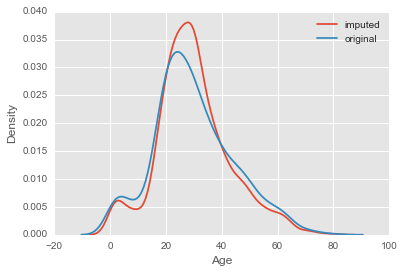

In [3260]:
imputed_ages = pd.DataFrame(filled_soft, columns = list(impute_missing))
sns.kdeplot(imputed_ages['Age'], label = 'imputed')
ax = sns.kdeplot(all_titanic['Age'], label = 'original')
ax.set(xlabel='Age', ylabel='Density');

The imputed data seems to be acceptable, so we'll use it for filling in the missing values in AgeClass and Title.

In [3261]:
all_titanic['Age'] = imputed_ages['Age']

# Fill in missing age class
all_titanic.loc[all_titanic['Age'] <= 10, 'AgeClass'] = 1
all_titanic.loc[(all_titanic['Age'] > 10) & (all_titanic['Age'] <= 20), 'AgeClass'] = 2
all_titanic.loc[(all_titanic['Age'] > 20) & (all_titanic['Age'] <= 35), 'AgeClass'] = 3
all_titanic.loc[all_titanic['Age'] >= 35, 'AgeClass'] = 4

# Fill in missing titles

# Drop the dummies title columns
all_titanic = all_titanic.drop(list(titles), axis = 1)

# Redo the titles
all_titanic['Title'] = create_titles(all_titanic['Name'])
all_titanic = condense_titles(all_titanic)

print(pd.crosstab(all_titanic['Title'], all_titanic['Age'] > 14.5))
all_titanic.loc[(all_titanic['Title'] == 'Master') & (all_titanic['Age'] > 14.5), 'Title'] = 'Mr'
all_titanic.loc[(all_titanic['Title'] == 'Miss') & (all_titanic['Age'] > 14.5), 'Title'] = 'Ms'
all_titanic.loc[(all_titanic['Title'] == 'Mr') & (all_titanic['Age'] <= 14.5), 'Title'] = 'Master'
print(pd.crosstab(all_titanic['Title'], all_titanic['Age'] > 14.5))

# Drop the title column and re-add the dummies
titles = pd.get_dummies(all_titanic['Title'])
all_titanic = pd.concat([all_titanic, titles], axis = 1)
all_titanic = all_titanic.drop(['Title'], axis = 1)

Age     False  True 
Title               
Master     59      8
Miss       50    210
Mr          0    776
Mrs         1    198
Ms          0      7
Age     False  True 
Title               
Master     59      0
Miss       50      0
Mr          0    784
Mrs         1    198
Ms          0    217


### Cabin
Missing cabin data can be imputed for people from the same family, assuming they shared the cabins or had cabins nearby.

In [3262]:
# Set CabinLetter equal to Cabin
all_titanic['CabinLetter'] = all_titanic['Cabin']

# For non-missing values, extract the first letter and save it as CabinLetter
letters = [cabin[:1] for cabin in all_titanic.loc[pd.notnull(all_titanic['CabinLetter']), 'CabinLetter']]
all_titanic.loc[pd.notnull(all_titanic['CabinLetter']), 'CabinLetter'] = letters

print("# of Missing Cabin Letters     : %d" % all_titanic['CabinLetter'].isnull().sum())
print("# of Non-missing Cabin Letters : %d" % all_titanic['CabinLetter'].notnull().sum())

# of Missing Cabin Letters     : 1014
# of Non-missing Cabin Letters : 295


In [3263]:
# Create a dataset of families with cabin data
family_with_cabin = all_titanic.loc[pd.notnull(all_titanic['CabinLetter']) & (all_titanic['SibSp'] + all_titanic['Parch'] > 0), ['FamilyName', 'CabinLetter']]
family_with_cabin = family_with_cabin.drop_duplicates()
family_with_cabin.head()

,FamilyName,CabinLetter
1,Cumings599,C
3,Futrelle803,C
10,Sandstrom549,G
27,Fortune950,C
31,Spencer569,B


For the passengers whose cabin letter is missing, see if their family name has an associated cabin letter. This ends up filling in the cabin letter for four passengers.

In [3264]:
def check_family_has_cabin(row):
    family_name = row['FamilyName']
    cabin_letter = row['CabinLetter']

    n_matches = sum(family_with_cabin['FamilyName'].str.contains(family_name))
    if n_matches > 0:
        value = family_with_cabin.loc[family_with_cabin['FamilyName'] == family_name, 'CabinLetter']
        cabin_letter = value.iloc[0]

    return(cabin_letter)

missing_cabins = all_titanic.loc[pd.isnull(all_titanic['CabinLetter']), ['FamilyName', 'CabinLetter']]
result = missing_cabins.apply(check_family_has_cabin, 1)

all_titanic.loc[pd.isnull(all_titanic['CabinLetter']), 'CabinLetter'] = result

print("# of Missing Cabin Letters     : %d" % all_titanic['CabinLetter'].isnull().sum())
print("# of Non-missing Cabin Letters : %d" % all_titanic['CabinLetter'].notnull().sum())

# of Missing Cabin Letters     : 1010
# of Non-missing Cabin Letters : 299


There are still many missing cabin letters. We'll use the proportions in the cross-tab below to fill them in. 

Per [Encycolpedia Titanica](https://www.encyclopedia-titanica.org/cabins.html) there is no evidence that anyone else occupied the "T" cabin, so we omit this when we impute.

In [3265]:
pd.crosstab(all_titanic['CabinLetter'], all_titanic['Pclass'])

Pclass,1,2,3
CabinLetter,,,
A,22,0,0
B,65,0,0
C,96,0,0
D,40,6,0
E,34,4,3
F,0,13,10
G,0,0,5
T,1,0,0


In [3266]:
pd.crosstab(pd.isnull(all_titanic['CabinLetter']), all_titanic['Pclass'])

Pclass,1,2,3
CabinLetter,,,
False,258,23,18
True,65,254,691


In [3267]:
# First class
A1 = round(22/258 * 65)
B1 = round(65/258 * 65)
C1 = round(96/258 * 65)
D1 = round(40/258 * 65)
E1 = 65 - (A1+B1+C1+D1)

# Second class
D2 = round(6/23 * 254)
E2 = round(4/23 * 254)
F2 = 254 - (D2+E2)

# Third class
E3 = round(3/18 * 691)
F3 = round(8/18 * 691)
G3 = 691 - (E3+F3)

all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 1) & (pd.isnull(all_titanic['CabinLetter']))].sample(A1, random_state=0).index, 
               'CabinLetter'] = ["A"] * A1
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 1) & (pd.isnull(all_titanic['CabinLetter']))].sample(B1, random_state=0).index, 
               'CabinLetter'] = ["B"] * B1
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 1) & (pd.isnull(all_titanic['CabinLetter']))].sample(C1, random_state=0).index, 
               'CabinLetter'] = ["C"] * C1
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 1) & (pd.isnull(all_titanic['CabinLetter']))].sample(D1, random_state=0).index, 
               'CabinLetter'] = ["D"] * D1
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 1) & (pd.isnull(all_titanic['CabinLetter']))].sample(E1, random_state=0).index, 
               'CabinLetter'] = ["E"] * E1

all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 2) & (pd.isnull(all_titanic['CabinLetter']))].sample(D2, random_state=0).index, 
               'CabinLetter'] = ["D"] * D2
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 2) & (pd.isnull(all_titanic['CabinLetter']))].sample(E2, random_state=0).index, 
               'CabinLetter'] = ["E"] * E2
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 2) & (pd.isnull(all_titanic['CabinLetter']))].sample(F2, random_state=0).index, 
               'CabinLetter'] = ["F"] * F2

all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 3) & (pd.isnull(all_titanic['CabinLetter']))].sample(E3, random_state=0).index, 
               'CabinLetter'] = ["E"] * E3
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 3) & (pd.isnull(all_titanic['CabinLetter']))].sample(F3, random_state=0).index, 
               'CabinLetter'] = ["F"] * F3
all_titanic.loc[all_titanic[(all_titanic['Pclass'] == 3) & (pd.isnull(all_titanic['CabinLetter']))].sample(G3, random_state=0).index, 
               'CabinLetter'] = ["G"] * G3


In [3268]:
pd.crosstab(all_titanic['CabinLetter'], all_titanic['Pclass'])

Pclass,1,2,3
CabinLetter,,,
A,28,0,0
B,81,0,0
C,120,0,0
D,50,72,0
E,43,48,118
F,0,157,317
G,0,0,274
T,1,0,0


In [3269]:
pd.crosstab(pd.isnull(all_titanic['CabinLetter']), all_titanic['Pclass'])

Pclass,1,2,3
CabinLetter,,,
False,323,277,709


Before continuing, we convert cabin letter to dummies. After that, we split back into separate training and test sets.

In [3270]:
cabin_letters = pd.get_dummies(all_titanic['CabinLetter'])
all_titanic = pd.concat([all_titanic, cabin_letters], axis = 1)
all_titanic = all_titanic.drop(['CabinLetter', 'Name', 'Ticket', 'Cabin', 'FamilyName'], axis = 1)

train = all_titanic.iloc[:891]
test = all_titanic.iloc[891:]

## Lasso and Ridge Models
### Training and validation sets
We'll split the dataset into separate male and female datasets, each with respective training and validation sets. We also drop columns that are no longer useful.

In [3271]:
train_male = train[train['Sex'] == 'male']
train_female = train[train['Sex'] == 'female']

test_male = test[test['Sex'] == 'male']
test_female = test[test['Sex'] == 'female']

train_male = train_male.drop(['Sex', 'Mother', 'Miss', 'Mrs', 'Ms'], axis = 1)
train_female = train_female.drop(['Sex', 'Master', 'Mr'], axis = 1)

test_male = test_male.drop(['Sex', 'Mother', 'Miss', 'Mrs', 'Ms'], axis = 1)
test_female = test_female.drop(['Sex', 'Master', 'Mr'], axis = 1)

# Create training and validation sets.
cv_train_male, cv_valid_male = cross_validation.train_test_split(train_male, test_size=0.25, random_state=0)
cv_train_female, cv_valid_female = cross_validation.train_test_split(train_female, test_size=0.25, random_state=0)

### Model training and prediction
#### Male Dataset

In [3272]:
# Split into X and y, per sklearn convention
y_m = cv_train_male['Survived']
X_m = cv_train_male.drop('Survived', axis=1)

# Use LogisticRegressionCV to get ridge (L2), 10 fold
clf_m_ridge = LogisticRegressionCV(Cs=500, cv=10, penalty='l2', random_state=0)
clf_m_ridge.fit(X_m, y_m)
print("Ridge Accuracy on training: %.3f" % clf_m_ridge.score(X_m, y_m))

# Use LogisticRegressionCV to get lasso (L1), 10 fold
clf_m_lasso = LogisticRegressionCV(Cs=500, cv=10, penalty='l1', solver='liblinear', random_state=0)
clf_m_lasso.fit(X_m, y_m)
print("Lasso Accuracy on training: %.3f" % clf_m_lasso.score(X_m, y_m))

y_m_valid = cv_valid_male['Survived']
X_m_valid = cv_valid_male.drop('Survived', axis = 1)
print("Ridge Accuracy on validation: %.3f" % clf_m_ridge.score(X_m_valid, y_m_valid))
print("Lasso Accuracy on validation: %.3f" % clf_m_lasso.score(X_m_valid, y_m_valid))
    

Ridge Accuracy on training: 0.856
Lasso Accuracy on training: 0.859
Ridge Accuracy on validation: 0.828
Lasso Accuracy on validation: 0.821


In [3273]:
def create_coef_table(coefs, features):
    df = pd.DataFrame({'coef': coefs, 'feature': features})
    df = df[['feature', 'coef']]
    df = df.reindex(df.coef.abs().sort_values(ascending=False).index)
    return(df)

create_coef_table(clf_m_ridge.coef_[0], list(X_m)).head(10)

,feature,coef
8,FamilySurvived,1.156
13,Master,0.516
14,Mr,-0.502
9,AgeClass,-0.404
4,Pclass,-0.403
5,SibSp,-0.392
15,A,0.380
19,E,0.348
6,FamilySize,0.343
20,F,-0.342


In [3274]:
# Helper function to print the confusion matrices per title.
def print_confusion_matrices(X, y, clf, titles):
    for title in titles:
        indexes = X.loc[X[title] == 1].index
        y_pred = clf.predict(X.loc[indexes]).astype(int)
        print(title)
        print(confusion_matrix(y.loc[indexes], y_pred))
    return 

# Training Set
print_confusion_matrices(X_m, y_m, clf_m_ridge, ['Master', 'Mr'])

Master
[[18  0]
 [ 1 14]]
Mr
[[337   2]
 [ 59   1]]


In [3275]:
# Validation Set
print_confusion_matrices(X_m_valid, y_m_valid, clf_m_ridge, ['Master', 'Mr'])

Master
[[1 0]
 [0 6]]
Mr
[[110   0]
 [ 25   3]]


In [3276]:
#### Female Dataset
# Split into X and y, per sklearn convention
y_f = cv_train_female['Survived']
X_f = cv_train_female.drop('Survived', axis=1)

# Use LogisticRegressionCV to get ridge (L2), 10 fold
clf_f_ridge = LogisticRegressionCV(Cs=500, cv=10, penalty='l2', random_state=0)
clf_f_ridge.fit(X_f, y_f)
print("Ridge Accuracy on training: %.3f" % clf_f_ridge.score(X_f, y_f))

# Use LogisticRegressionCV to get lasso (L1), 10 fold
clf_f_lasso = LogisticRegressionCV(Cs=500, cv=10, penalty='l1', solver='liblinear', random_state=0)
clf_f_lasso.fit(X_f, y_f)
print("Lasso Accuracy on training: %.3f" % clf_f_lasso.score(X_f, y_f))

y_f_valid = cv_valid_female['Survived']
X_f_valid = cv_valid_female.drop('Survived', axis = 1)
print("Ridge Accuracy on validation: %.3f" % clf_f_ridge.score(X_f_valid, y_f_valid))
print("Lasso Accuracy on validation: %.3f" % clf_f_lasso.score(X_f_valid, y_f_valid))


Ridge Accuracy on training: 0.902
Lasso Accuracy on training: 0.898
Ridge Accuracy on validation: 0.949
Lasso Accuracy on validation: 0.937


In [3277]:
create_coef_table(clf_f_ridge.coef_[0], list(X_f)).head(10)

,feature,coef
9,FamilySurvived,5.055
8,Single,2.361
19,C,-2.005
4,Pclass,-1.520
6,FamilySize,-0.809
18,B,0.678
13,S,-0.589
20,D,0.546
2,Parch,-0.523
21,E,0.471


In [3278]:
create_coef_table(clf_f_lasso.coef_[0], list(X_f)).head(10)

,feature,coef
9,FamilySurvived,3.968
8,Single,1.896
4,Pclass,-0.595
2,Parch,-0.266
5,SibSp,-0.172
0,Age,0.013
1,Fare,0.004
3,PassengerId,0.000
11,C,0.000
6,FamilySize,0.000


In [3279]:
# Training Set
print_confusion_matrices(X_f, y_f, clf_f_ridge, ['Miss', 'Mrs', 'Ms'])

Miss
[[10  1]
 [ 0 10]]
Mrs
[[21  3]
 [ 1 75]]
Ms
[[18 13]
 [ 5 78]]


In [3280]:
# Validation Set
print_confusion_matrices(X_f_valid, y_f_valid, clf_f_ridge, ['Miss', 'Mrs', 'Ms'])

Miss
[[ 3  1]
 [ 0 13]]
Mrs
[[ 2  0]
 [ 0 25]]
Ms
[[ 6  3]
 [ 0 26]]


In [3281]:
# Predict for test set
X_m_test = test_male.drop('Survived', axis=1)
X_f_test = test_female.drop('Survived', axis=1)

m_predict = clf_m_ridge.predict(X_m_test)
f_predict = clf_f_lasso.predict(X_f_test)

submission_m = pd.DataFrame({'PassengerId': X_m_test['PassengerId'], 
                            'Survived': m_predict.astype(int)})
submission_f = pd.DataFrame({'PassengerId': X_f_test['PassengerId'], 
                            'Survived': f_predict.astype(int)})

submission = submission_m.append(submission_f)

print(sum(submission['Survived'] == 0))
print(sum(submission['Survived'] == 1))

submission = submission.reindex(submission.PassengerId.sort_values().index)

submission.to_csv("submission_huey.csv", index=False)

296
122


### Debugging Notes
Things that differ most from the R version, ordered from largest estimated effect to smallest:
* Results from MICE to impute Age
* DecisionTree to decide Missing FARE
* Imputed two cabin letters correctly, i.e. believe the original author had a bug
* Dropped FamilyName

RidgeMale, RidgeFemale:
0.77990

RidgeMale, LassoFemale:
0.78469

#### Using features from R, dropped family_name:
RidgeMale, RidgeFemale: 
0.77033

#### Adding family_names using pd_dummies:
RidgeMale, RidgeFemale:
0.77033

#### Changing Cs from default 10 to 100:
RidgeMale, RidgeFemale: 301/107
0.79426

RidgeMale, LassoFemale:
0.78947

#### Changing Cs from 100 to 500:
RidgeMale, RidgeFemale: 312/106
0.7655

RidgeMale, LassoFemale:
0.78947

#### our Using feature engineering:
RidgeMale, RidgeFemale:
0.78947

RidgeMale, LassoFemale:
0.78469

#### Changing Cs from 100 to 500:
RidgeMale, RidgeFemale:
0.78469 -> 0.77990

RidgeMale, LassoFemale:
0.79904 -> 0.77033? (not sure what accounts for the difference)

#### Changing Cs from 500 to 100:
RM, RF:
0.80383

RM, LF:
0.77512

#### Set Random Seed for MICE
RM, RF:
0.76077

RM, LF:
0.78469

#### Running again to ensure there's no randomness
RM, RF: 318/10
0.77990

RM, LF: 296/122, 298/120, 295/123, 293/125, 298/120, 295/123, 300/118, 300/118, 300/118
0.78947

#### Changing Cs from 100 to 500:
RM, RF: 314/104
0.78469

RM, LF: 296/122
0.79904